# Climate Change

The goal of this project is to practice SQL *windows functions*, ascertaining different climate change insights within "Global Land and Ocean Temperatures" dataset in the process. This particular dataset comes from [Kaggle](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalLandTemperaturesByState.csv). The raw data are collected by [Berkeley Earth](https://berkeleyearth.org/data/).

Window functions allow maintaining the values of original table while displaying grouped or summative information alongside in another column. This is why many Data Scientists and Data Engineers frequently use window functions for complex data analysis.


Columns description:

- `Date`: starts in 1750 for average land temperature and 1850 for max and min land temperatures and global ocean and land temperatures
- `LandAverageTemperature`: global average land temperature in celsius
- `LandAverageTemperatureUncertainty`: the 95% confidence interval around the average
- `LandMaxTemperature`: global average maximum land temperature in celsius
- `LandMaxTemperatureUncertainty`: the 95% confidence interval around the maximum land temperature
- `LandMinTemperature:` global average minimum land temperature in celsius
- `LandMinTemperatureUncertainty`: the 95% confidence interval around the minimum land temperature
- `LandAndOceanAverageTemperature`: global average land and ocean temperature in celsius
- `LandAndOceanAverageTemperatureUncertainty`: the 95% confidence interval around the global average land and ocean temperature

### Data Investigation

Let's start with data imports and data investigation. 

In [1]:
# Basic imports related to analysis
import pandas as pd
import numpy as np 

# Imports related to database management
import sqlite3

# Import for visualisation
import seaborn as sns
from matplotlib import pyplot as plt

Let's see what data our `climate_data.csv` contains. We are going to convert it to `pandas` `DataFrame` and after that create a new SQL database from it.

In [2]:
# Read csv to DataFrame
temps = pd.read_csv("GlobalTemperatures.csv")
temps.head(2)

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1850-01-01,0.749,1.105,8.242,1.738,-3.206,2.822,12.833,0.367
1,1850-02-01,3.071,1.275,9.970,3.007,-2.291,1.623,13.588,0.414


While uncertainties are useful information for extended research we won't need them for our short practice, so let's limit our columns to averages, mins, maxes and dates.

In [3]:
# Copy to new DataFrame only relevant columns
temps_avg = temps[['dt', 'LandAverageTemperature', 'LandMaxTemperature', 'LandMinTemperature', 'LandAndOceanAverageTemperature']].copy()
temps_avg.head(2)

,dt,LandAverageTemperature,LandMaxTemperature,LandMinTemperature,LandAndOceanAverageTemperature
0,1850-01-01,0.749,8.242,-3.206,12.833
1,1850-02-01,3.071,9.970,-2.291,13.588


### Database Creation

Now let's write records of this DataFrame to a new table in the database. 

In [4]:
# Create new db
connect = sqlite3.connect('./climate_change.db')

# Create new table in db
temps_avg.to_sql('Temperatures', connect, if_exists='replace', index=False)

# Create db cursor
cursor = connect.cursor()

To see results in a table view and make visualizations in the future we'll have to convert SQL return results back to `DataFrames`.

In [5]:
def sql(*args, **kwargs):
    cur = cursor.execute(*args, **kwargs)
    return pd.DataFrame(cur.fetchall(), columns=[column_name[0] for column_name in cur.description])

# Display first 5 rows of table
sql('''
    SELECT *
    FROM Temperatures
    LIMIT 2
''')


,dt,LandAverageTemperature,LandMaxTemperature,LandMinTemperature,LandAndOceanAverageTemperature
0,1850-01-01,0.749,8.242,-3.206,12.833
1,1850-02-01,3.071,9.970,-2.291,13.588


Just in case, let's see if there are any `null`s in our table.

In [6]:
sql('''
    SELECT  
        COUNT(*) - COUNT(dt),
        COUNT(*) - COUNT(LandAverageTemperature),
        COUNT(*) - COUNT(LandMaxTemperature),
        COUNT(*) - COUNT(LandMinTemperature),
        COUNT(*) - COUNT(LandAndOceanAverageTemperature)
    FROM Temperatures
''')

,COUNT(*) - COUNT(dt),COUNT(*) - COUNT(LandAverageTemperature),COUNT(*) - COUNT(LandMaxTemperature),COUNT(*) - COUNT(LandMinTemperature),COUNT(*) - COUNT(LandAndOceanAverageTemperature)
0,0,0,0,0,0


No `null`s, which is unusual, but we took only recent data, the full dataset consists of measurements dated around 1700s, and there were a lot of `null`s within such old data, because not everything could have been measured correctly using much simpler equipment than stations have today.

## Aggregate and Value Functions

Let’s start by looking at how the temperature changes over time on 10-year intervals. 

In [7]:
avgs = sql('''
    SELECT
        CAST(year AS INTEGER) AS 'Year',
        year_average AS 'Year Average',
        AVG(year_average) OVER (
            ORDER BY year
            ROWS BETWEEN 9 PRECEDING AND 0 FOLLOWING
        ) AS `10 Years Running Average`

    FROM (
        SELECT
            strftime('%Y', t1.dt) AS year,
            AVG(t1.LandAverageTemperature) AS year_average
        FROM Temperatures t1
        GROUP BY year);
''')

# Display first 5 rows and last
def top_bottom(avgs, x=5):
    return pd.concat([ avgs.head(x), (avgs.tail(x))])
top_bottom(avgs, 5)

,Year,Year Average,10 Years Running Average
0,1850,7.900667,7.900667
1,1851,8.178583,8.039625
2,1852,8.100167,8.059806
3,1853,8.041833,8.055312
4,1854,8.210500,8.086350
161,2011,9.516000,9.554225
162,2012,9.507333,9.547917
163,2013,9.606500,9.556008
164,2014,9.570667,9.580617
165,2015,9.831000,9.593625


In [8]:
avgs_oc = sql('''
    SELECT
        CAST(year AS INTEGER) AS 'Year',
        ocean_year_average AS 'Land & Ocean Year Average',
        AVG(ocean_year_average) OVER (
            ORDER BY year
            ROWS BETWEEN 9 PRECEDING AND 0 FOLLOWING
        ) AS `Land & Ocean 10 Years Running Average`

    FROM (
        SELECT
            strftime('%Y', t1.dt) AS year,
            AVG(t1.LandAndOceanAverageTemperature) AS ocean_year_average
        FROM Temperatures t1
        GROUP BY year);
''')

# Display first 5 rows and last
def top_bottom(avgs_oc, x=5):
    return pd.concat([ avgs_oc.head(x), (avgs_oc.tail(x))])
top_bottom(avgs_oc, 5)

,Year,Land & Ocean Year Average,Land & Ocean 10 Years Running Average
0,1850,14.867167,14.867167
1,1851,14.991833,14.929500
2,1852,15.006500,14.955167
3,1853,14.955167,14.955167
4,1854,14.991000,14.962333
161,2011,15.769500,15.814650
162,2012,15.802333,15.811967
163,2013,15.854417,15.814750
164,2014,15.913000,15.830325
165,2015,16.058583,15.848258


In [9]:
maxs = sql('''
    SELECT
        CAST(year AS INTEGER) AS 'Year',
        max_temp AS 'Year Maximum',
        MAX(max_temp) OVER (
            ORDER BY year
            ROWS BETWEEN 9 PRECEDING AND 0 FOLLOWING
        ) AS `Maximum Temperature over 10 years`
    FROM (
        SELECT
            strftime('%Y', t1.dt) AS year,
            MAX(t1.LandMaxTemperature) AS max_temp
        FROM Temperatures t1
        GROUP BY year);
''')

# Display first 5 rows and last
top_bottom(maxs, 5)

,Year,Year Maximum,Maximum Temperature over 10 years
0,1850,19.233,19.233
1,1851,17.361,19.233
2,1852,17.795,19.233
3,1853,19.308,19.308
4,1854,20.426,20.426
161,2011,21.320,21.320
162,2012,21.006,21.320
163,2013,20.737,21.320
164,2014,20.790,21.320
165,2015,20.904,21.320


In [10]:
mins = sql('''
    SELECT
        CAST(year AS INTEGER) AS 'Year',
        min_temp AS 'Year Minimum',
        MIN(min_temp) OVER (
            ORDER BY year
            ROWS BETWEEN 9 PRECEDING AND 0 FOLLOWING
        ) AS `Minimum Temperature over 10 years`
    FROM (
        SELECT
            strftime('%Y', t1.dt) AS year,
            MIN(t1.LandMinTemperature) AS min_temp
        FROM Temperatures t1
        GROUP BY year);
''')

# Display first 5 rows and last
top_bottom(mins, 5)

,Year,Year Minimum,Minimum Temperature over 10 years
0,1850,-3.206,-3.206
1,1851,-3.242,-3.242
2,1852,-2.755,-3.242
3,1853,-4.015,-4.015
4,1854,-4.109,-4.109
161,2011,-2.034,-2.383
162,2012,-2.233,-2.383
163,2013,-1.726,-2.383
164,2014,-2.080,-2.383
165,2015,-1.518,-2.383


In [11]:
avgs_melted=avgs.melt(
      # Column to use as identifier variables
      id_vars='Year',
      # Column name to use for “variable” names/column headers
      var_name='Type',
      # Column name for the values originally in the columns 
      value_name='Value'
      )

maxs_melted=maxs.melt(id_vars='Year', var_name='Type', value_name='Value')
mins_melted=mins.melt(id_vars='Year', var_name='Type', value_name='Value')
avgs_oc_melted=avgs_oc.melt(id_vars='Year', var_name='Type', value_name='Value')

avgs_melted

,Year,Type,Value
0,1850,Year Average,7.900667
1,1851,Year Average,8.178583
2,1852,Year Average,8.100167
3,1853,Year Average,8.041833
4,1854,Year Average,8.210500
...,...,...,...
327,2011,10 Years Running Average,9.554225
328,2012,10 Years Running Average,9.547917
329,2013,10 Years Running Average,9.556008
330,2014,10 Years Running Average,9.580617


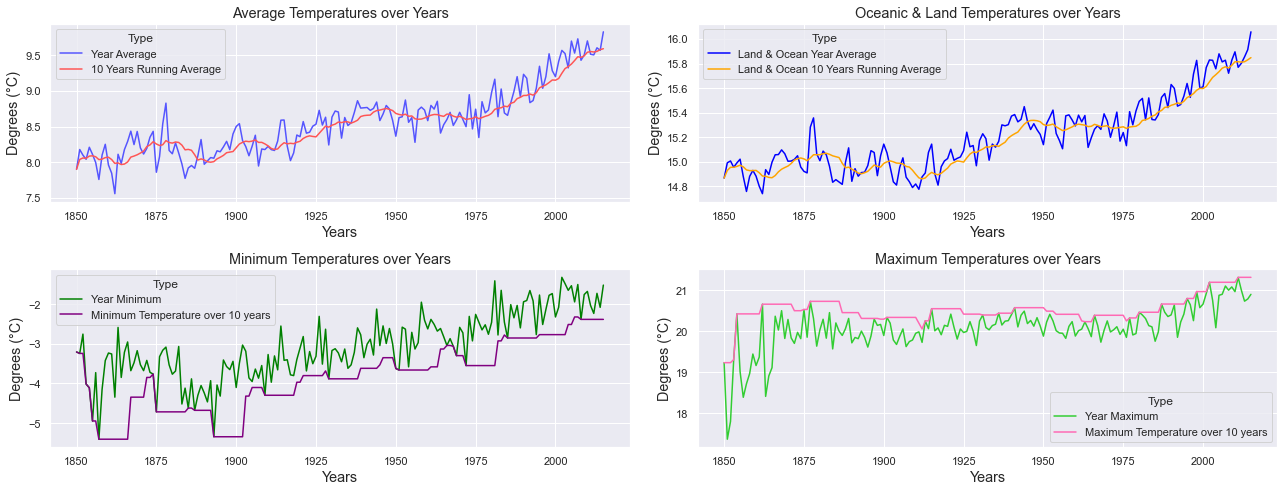

In [12]:
# Set darkgrid for all plots of the project
sns.set(style='darkgrid')

def linears(dfs, palette, titles):
    # Set up grid for plotting.
    fig, sub = plt.subplots(2, 2, figsize=(18,7))

    # Draw scatterplots
    for data_set, title, ax, colors in zip(dfs, titles, sub.flatten(), palette):
        sns.lineplot(x=data_set.Year, y=data_set.Value, hue=data_set.Type, palette=colors, legend=True, ax=ax)

        # Set up labels
        ax.set_title(title, fontsize='large')
        ax.set_xlabel('Years', fontsize='large')
        ax.set_ylabel('Degrees (°C)', fontsize='large')

    fig.tight_layout()
    return plt.show()

linears(
    # Data for plots    
    dfs = (
        avgs_melted,
        avgs_oc_melted,
        mins_melted,
        maxs_melted        
        ),
    # Colors for plots    
    palette = [
        'seismic',
        ['Blue', 'Orange'], 
        ['Green', 'Purple'], 
        ['LimeGreen', 'HotPink']
        ],
    # Title for plots
    titles = (
        'Average Temperatures over Years',
        'Oceanic & Land Temperatures over Years',
        'Minimum Temperatures over Years',
        'Maximum Temperatures over Years'
    )
)

Now let's find out when were periods of the most drastic temperature change by comparing current year with previous one. 

In [34]:
change_in_avg = sql('''
    SELECT
    CAST(year AS INTEGER) AS 'Year',
    LandAverageTemperature AS 'Year Average',
    LandAverageTemperature - LAG(LandAverageTemperature, 1, LandAverageTemperature) OVER (
        ORDER by year
    ) AS 'Change in Averages'
    FROM (
        SELECT
            strftime('%Y', t1.dt) AS year,
            AVG(t1.LandAverageTemperature) AS LandAverageTemperature
        FROM Temperatures t1
        GROUP BY year);
''')


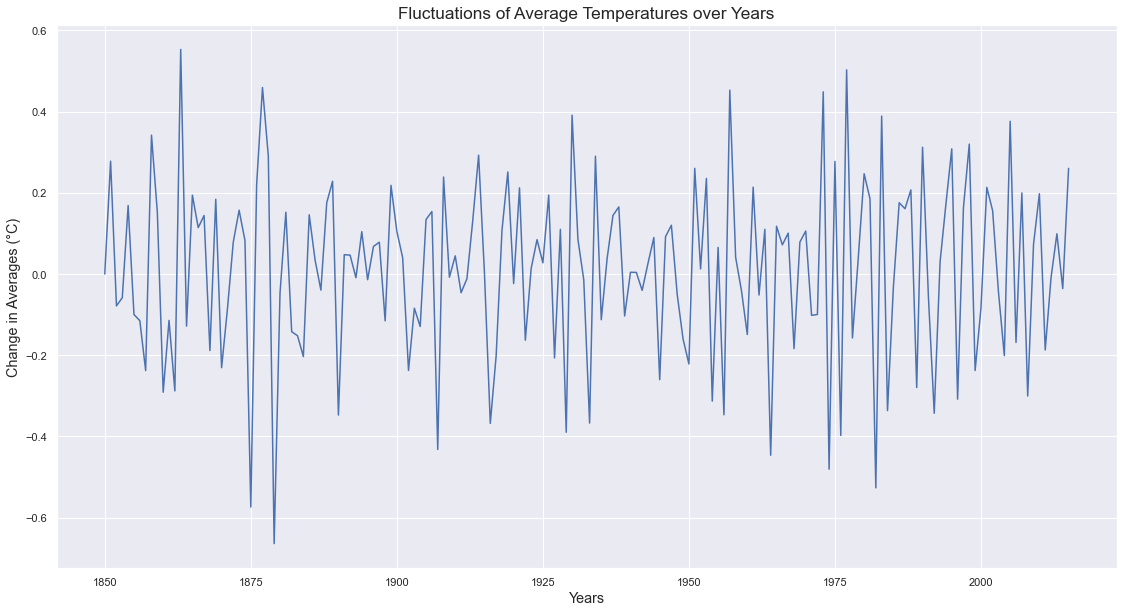

In [44]:
plt.figure(figsize = (19,10))
sns.lineplot(data=change_in_avg, x='Year', y='Change in Averages')
plt.title('Fluctuations of Average Temperatures over Years', fontsize= 'x-large')
plt.xlabel('Years', fontsize= 'large')
plt.ylabel('Change in Averages (°C)', fontsize= 'large')
plt.show()


### Ranking Functions

TBC